
# Clouds Step By Step

Reconstruct and event with clouds, step by step.

Didactic and debugin purposes.

#### JA Hernando, April 2021

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import numpy             as np
import matplotlib.pyplot as plt

import clouds.clouds    as clouds
import clouds.pltclouds as pltclouds

import clouds.ridges    as ridges

In [3]:
plt.rcParams['image.cmap'] = 'Blues'

import warnings
warnings.filterwarnings('ignore')

import time
print(' Last revision ', time.asctime())

 Last revision  Thu May  6 11:18:26 2021


## Generate an event


Generate points along a line with a given dispersion in (x, y)

## Generate sample

In [4]:
def canvas(nx = 1, ny = 1, xsize = 4., ysize = 5):
    plt.figure(figsize = (ny * ysize, nx * xsize))
    subplot = lambda i : plt.subplot(nx, ny, i)
    return subplot

In [5]:
def generate_points(sizes, line = None, sigma = 1):
    
    size0   = np.min(sizes)
    npoints = len(sizes)
    ts = np.linspace(0, 1., npoints)
    ts = [ni * [ti,] for ni, ti in zip(sizes, ts)]
    ts.append(np.random.uniform(size = size0))
    ts = np.concatenate(ts)

    size = len(ts)
    iden = lambda x: x
    x, y = (iden, iden) if line is None else line
    xs   = x(ts) + sigma * np.random.normal(size = size)
    ys   = y(ts) + sigma * np.random.normal(size = size)
    
    return xs, ys

In [129]:
sizes = 1000 * np.array((3, 1, 3, 1, 3, 1, 1, 1, 2, 1, 2))
scale, offset = 10, 2
line  = lambda x: scale * x,  lambda x: offset + scale * x
xs, ys = generate_points(sizes, line, sigma = 0.5)

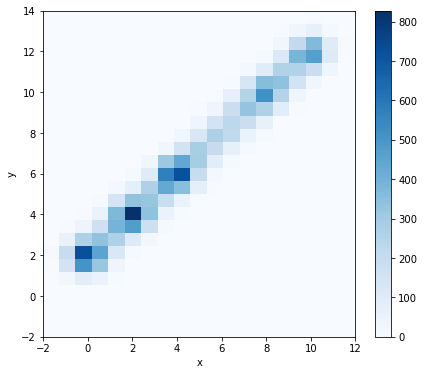

In [130]:
size  = 2
xbins = np.linspace(-2, scale + 2, size * 10)
ybins = np.linspace(-2, scale + 2 + offset, size * 13)

bins          = (xbins, ybins)
counts, _, _  = np.histogram2d(xs, ys, bins = bins)

subplot = canvas(1, 1, 6, 7)
subplot(1)
plt.hist2d(xs, ys, bins);
#plt.imshow(counts.T, origin = 'lower')
plt.xlabel('x'); plt.ylabel('y')
plt.colorbar();

## Clouds input

   * Input data are:
       
       * coors   : a list of coordinates of the points: (x, y)
       
       * steps   : a list with the steps in each dimention (x-step, y-step)
       
       * weights : the weigths or energy of each point (ene)

In [131]:
coors   = (xs, ys)
steps   = (xbins[1] - xbins[0], ybins[1] - ybins[0])
weights = np.ones(len(xs))

## 1 Clouds - Execute


In [132]:
bins, mask, cells, df = clouds.clouds(coors, steps, weights)

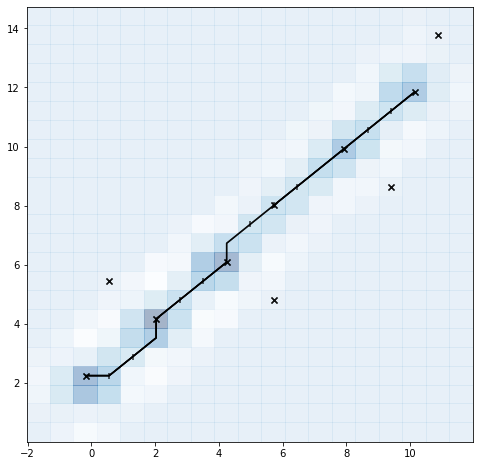

In [133]:
plt.figure(figsize = (8, 8));
draw = pltclouds.drawer(cells, bins, df, 'p')
draw(ispass = True);

## Graph matrix 


In [134]:
prefix    = 'e'
cenes     = df[prefix + 'value']   .values
cnode     = df[prefix + 'node']    .values
cisborder = df[prefix + 'isborder'].values
cepath    = df[prefix + 'path']    .values

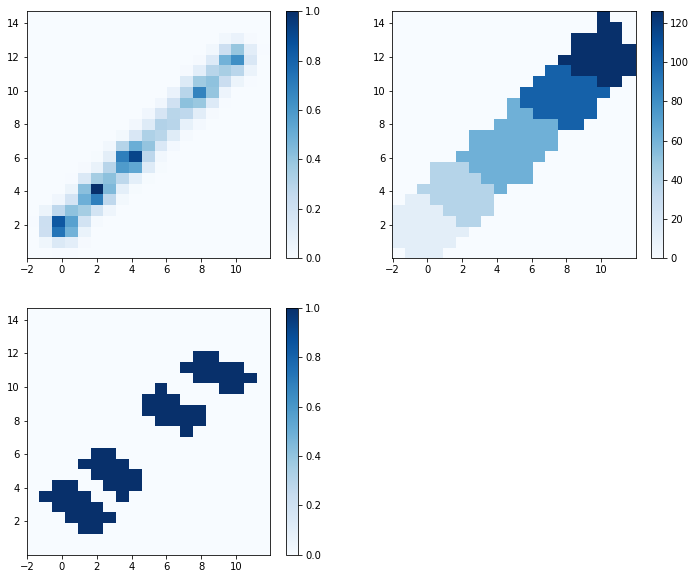

In [135]:
plt.figure(figsize = ( 2* 6, 2* 5))

plt.subplot(2, 2, 1)
plt.hist2d(*cells, bins = bins, weights = cenes);
plt.colorbar()

plt.subplot(2, 2, 2)
plt.hist2d(*cells, bins = bins, weights = cnode);
plt.colorbar();

plt.subplot(2, 2, 3)
plt.hist2d(*cells, bins = bins, weights = cisborder);
plt.colorbar();

In [221]:
nodes, nenes, elinks, nlinks = clouds._graph_matrix(bins, mask, cells, cenes, cnode, cisborder)

cells ids  [ 55  79  46  29  87 110  20 119]


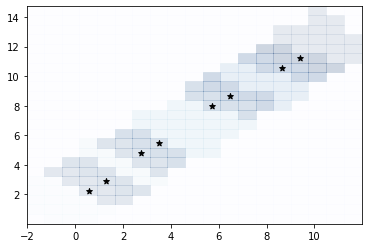

In [238]:
cells_select = clouds.cells_select
plt.hist2d(*cells, bins = bins, weights = cnode, alpha = 0.1);
plt.hist2d(*cells, bins = bins, weights = cisborder, alpha = 0.1);
uids = nlinks.flatten().astype(int)
uids = uids[uids >= 0]
print('cells ids ', uids)
plt.scatter(*cells_select(cells, uids), marker = '*', color = 'black');

## Get the paths

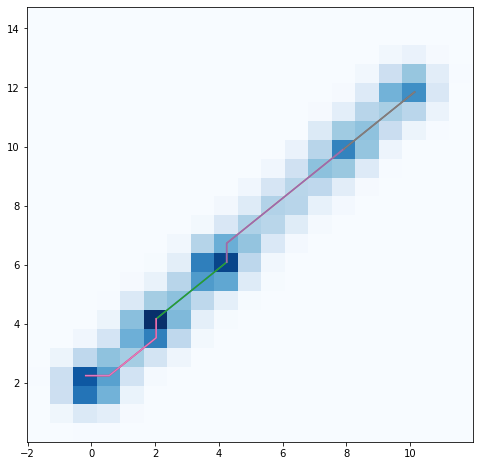

In [239]:
paths    = clouds._graph_paths(nodes, nlinks, cepath)
segments = [clouds.get_segment(cells, path) for path in paths]

plt.figure(figsize = (8, 8))
plt.hist2d(*cells, bins, weights = cenes)
for segment in segments:
    plt.plot(*segment);

## Minimum Spanning Tree

In [287]:
import scipy.sparse.csgraph as scgraph

In [288]:
ulinks = clouds._graph_mat(elinks)
print(ulinks)

[[0.         1.83059418 1.43489254 0.         0.        ]
 [1.83059418 0.         0.         1.74083439 0.        ]
 [1.43489254 0.         0.         0.         1.5840708 ]
 [0.         1.74083439 0.         0.         0.        ]
 [0.         0.         1.5840708  0.         0.        ]]


In [306]:
data = scgraph.minimum_spanning_tree(ulinks)
#print(data.indices)
#help(data)
print(data)
mat  = data.toarray()
indices = [list(kid) for kid in np.argwhere(mat > 0)]
print(indices)
#mat += mat.T
print(mat)

  (0, 1)	1.8305941845764855
  (0, 2)	1.4348925410872315
  (1, 3)	1.7408343868520861
  (2, 4)	1.584070796460177
[[0, 1], [0, 2], [1, 3], [2, 4]]
[[0.         1.83059418 1.43489254 0.         0.        ]
 [0.         0.         0.         1.74083439 0.        ]
 [0.         0.         0.         0.         1.5840708 ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]]


In [298]:
i0 = kid_extr[0]
print('extreme initial ', i0)

print('mat ', mat)
degrees  = np.sum(mat > 0, 1)
print('degrees ', degrees)
kid_extr = np.where(degrees == 0)[0]
ene_extr = np.sum(mat, 1)[kid_extr]
ene_extr, kid_extr = clouds.ut_sort(ene_extr, kid_extr, reverse = False)
print('ordered ', ene_extr, kid_extr)

def _get_path(mat, i0):
    path = [i0,]
    j0   =  i0
    while j0 >= 0:
        js = list(np.argwhere(mat[j0, :] >0).flatten())
        print(' mat   ', j0, mat[j0, :])
        print(' index ', j0, js)
        j0 = -1
        for ji in js:
            if (not np.isin(ji, path)):
                path.append(ji)
                j0 = ji
                print('  select ', j0)
                print('  path   ', path)
    return path
    

extreme initial  3
mat  [[0.         1.83059418 1.43489254 0.         0.        ]
 [0.         0.         0.         1.74083439 0.        ]
 [0.         0.         0.         0.         1.5840708 ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]]
degrees  [2 1 1 0 0]
ordered  [0. 0.] [3 4]


In [291]:
degrees  = np.sum(mat > 0, 1)
print('degrees ', degrees)
kid_extr = np.where(degrees == 1)[0]
ene_extr = np.sum(mat, 1)[kid_extr]
ene_extr, kid_extr = clouds.ut_sort(ene_extr, kid_extr, reverse = False)
print('ordered ', ene_extr, kid_extr)


degrees  [2 1 1 0 0]
ordered  [1.5840708  1.74083439] [2 1]


In [309]:
links    = clouds._graph_links_mstree(elinks, nlinks)
print(links)
paths    = [clouds.get_path_from_link(*ilink, cepath) for ilink in links]
segments = [clouds.get_segment(cells, path) for path in paths]

mat  [[0.         1.83059418 1.43489254 0.         0.        ]
 [0.         0.         0.         1.74083439 0.        ]
 [0.         0.         0.         0.         1.5840708 ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]]
degrees  [2 1 1 0 0]
ordered  [1.5840708  1.74083439] [2 1]
extreme initial  2
[[0, 1], [0, 2], [1, 3], [2, 4]]
[[ -1  55  79  -1  -1]
 [ 46  -1  -1  29  -1]
 [ 87  -1  -1  -1 110]
 [ -1  20  -1  -1  -1]
 [ -1  -1 119  -1  -1]]
[(55, 46), (79, 87), (29, 20), (110, 119)]


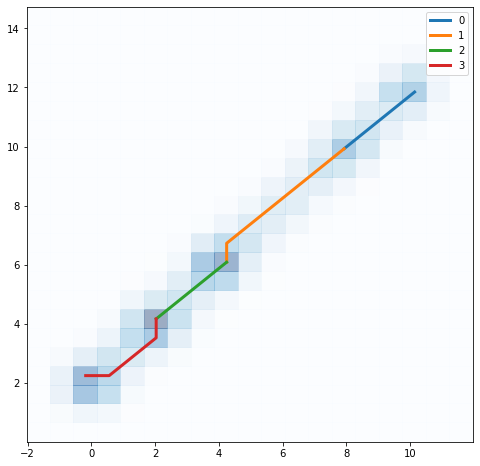

In [274]:
plt.figure(figsize = (8, 8))
plt.hist2d(*cells, bins, weights = cenes, alpha = 0.4);
for i, segment in enumerate(segments):
    plt.plot(*segment, lw = 3, label = str(i));
plt.legend();

## Shortest path

In [284]:
links = clouds._graph_links_shortestdist(elinks, nlinks)
print(links)
paths    = [clouds.get_path_from_link(*ilink, cepath) for ilink in links]
segments = [clouds.get_segment(cells, path) for path in paths]

[(20, 29), (46, 55), (79, 87), (110, 119)]


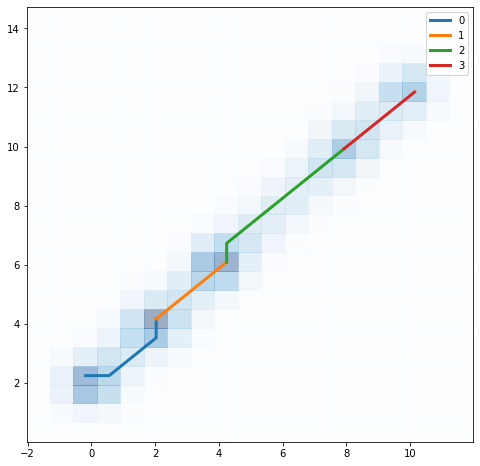

In [285]:
plt.figure(figsize = (8, 8))
plt.hist2d(*cells, bins, weights = cenes, alpha = 0.4);
for i, segment in enumerate(segments):
    plt.plot(*segment, lw = 3, label = str(i));
plt.legend();